<a href="https://colab.research.google.com/github/MrCoeg/Age-Of-Early-Universe/blob/main/Project_UAS_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !unzip '/content/drive/MyDrive/Dataset/rgb.zip' -d '/content/drive/MyDrive/Dataset'

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm


INDEX_KEYPOINTS = [0,2,4,5,8,9,12,13,16,17,20]
N_KEYPOINTS = 11
N_IMG_CHANNELS = 3
RAW_IMG_SIZE = 224
MODEL_IMG_SIZE = 128
DATASET_MEANS = [0.4837, 0.4650, 0.4397]
DATASET_STDS = [0.2331, 0.2338, 0.2659]
MODEL_NEURONS = 16

# COLORMAP = {
#     "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
#     "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
#     "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
#     "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
#     "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
# }

COLORMAP = {
    "thumb": {"ids": [0, 1, 2], "color": "g"},
    "index": {"ids": [0, 3, 4], "color": "c"},
    "middle": {"ids": [0, 5, 6], "color": "b"},
    "ring": {"ids": [0, 7, 8], "color": "m"},
    "little": {"ids": [0, 9, 10], "color": "r"},
}

def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    uv = uv[:, :2] / uv[:, -1:]    
    return uv[INDEX_KEYPOINTS]


def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for i, sample in tqdm(enumerate(dataloader)):
        data = sample["image_raw"]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}


def vector_to_heatmaps(keypoints):
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])
    for k, (x, y) in enumerate(keypoints):
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    heatmaps = blur_heatmaps(heatmaps)
    return heatmaps


def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (51, 51), 3)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred


class IoULoss(nn.Module):

    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


def heatmaps_to_coordinates(heatmaps):
    batch_size = heatmaps.shape[0]
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])
    normalized = heatmaps / sums
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, N_KEYPOINTS, 1])
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)
    keypoints = np.stack([x, y], axis=-1)
    return keypoints / 128

def show_data(dataset, n_samples=4):
    # n_cols = (int)(n_samples/2)
    # n_rows = 2
    # plt.figure(figsize=[15, n_rows * 4])
    plt.figure(figsize=[12, 4 * n_samples])

    ids = np.random.choice(dataset.__len__(), n_samples-1, replace=False)
    print(ids)
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image_raw = sample["image_raw"].numpy()
        image_raw = np.moveaxis(image_raw, 0, -1)

        plt.subplot(n_samples, 4, i * 4 + 1)
        plt.imshow(image_raw)
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Raw Image Keypoint")
        plt.axis("off")

        plt.subplot(n_samples, 4, i * 4 + 2)
        image = sample["image"].numpy() * 225
        cv2.resize(image, (RAW_IMG_SIZE,RAW_IMG_SIZE))
        image = np.moveaxis(image, 0, -1)
        plt.imshow(image)

        heatmaps = sample["heatmaps"].numpy()
        input_keypoints = heatmaps_to_coordinates(heatmaps.reshape(1, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))
        input_keypoints = input_keypoints[0] * MODEL_IMG_SIZE;

        plt.scatter(input_keypoints[:, 0], input_keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                input_keypoints[params["ids"], 0],
                input_keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Input Image")
        plt.axis("off")
        
        image_raw = image_raw * 255
        plt.subplot(n_samples, 4, i * 4 + 3)
        plt.hist(image_raw.ravel(),256,[0,256])
        plt.title("Raw Hist")
        plt.axis("off")

        plt.subplot(n_samples, 4, i * 4 + 4)
        plt.hist(image.ravel(),256,[0,256])
        plt.title("Input Hist")
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()


def show_batch_predictions(batch_data, model):
    inputs = batch_data["image"]
    true_keypoints = batch_data["keypoints"].numpy()
    batch_size = true_keypoints.shape[0]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
    images = batch_data["image"].numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])
    for i in range(batch_size):
        image = images[i]
        image = cv2.resize(image, (RAW_IMG_SIZE, RAW_IMG_SIZE))
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        plt.subplot(batch_size, 2, i * 2 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(batch_size, 2, i * 2 + 2)
        plt.imshow(image)
        plt.scatter(pred_keypoints_img[:, 0], pred_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

In [23]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import random

class FreiHAND(Dataset):

    def __init__(self, config, set_type="train"):
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "training/rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        self.image_names = [img for img in self.image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]

        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        if set_type == "train":
            n_start = 0
            n_end = 12000
        elif set_type == "val":
            n_start = 12000
            n_end = 14000
        else:
            n_start = 5000
            n_end = 6000
            
        #n_start = 0
        #n_end = 4

        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]

        self.image_raw_transform = transforms.ToTensor()
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        self.image_transform_flipped_horizontal = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomHorizontalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        self.image_transform_flipped_vertical = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        self.image_transform_flipped_both = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomHorizontalFlip(1),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_raw = Image.open(os.path.join(self.image_dir, image_name))

        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])
        keypoints = keypoints / RAW_IMG_SIZE
        heatmaps = vector_to_heatmaps(keypoints)
        heatmaps = torch.from_numpy(np.float32(heatmaps))
        flip_probability = random.random()
        if 0 < flip_probability < 0.25:
          image = self.image_transform(image_raw)
        elif 0.25 < flip_probability < 0.5:
          image = self.image_transform_flipped_horizontal(image_raw)
          heatmaps = transforms.functional.hflip(heatmaps)
        elif 0.5 < flip_probability < 0.75:
          image = self.image_transform_flipped_vertical(image_raw)
          heatmaps = transforms.functional.vflip(heatmaps)
        else:
          image = self.image_transform_flipped_both(image_raw)
          heatmaps = transforms.functional.hflip(heatmaps)
          heatmaps = transforms.functional.vflip(heatmaps)
        image_raw = self.image_raw_transform(image_raw)
        keypoints = torch.from_numpy(keypoints)

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }


In [5]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ShallowUNet(nn.Module):

    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv_down1 = ConvBlock(in_channel, MODEL_NEURONS)
        self.conv_down2 = ConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = ConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_bottleneck = ConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        self.maxpool = nn.MaxPool2d(2)
        self.upsamle = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv_up1 = ConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up2 = ConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up3 = ConvBlock(MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS)

        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        conv_d1 = self.conv_down1(x)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

        conv_u1 = self.conv_up1(torch.cat([self.upsamle(conv_b), conv_d3], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsamle(conv_u1), conv_d2], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsamle(conv_u2), conv_d1], dim=1))

        out = self.conv_out(conv_u3)
        return out

In [16]:
import numpy as np
import torch


class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 100
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )

            # reducing LR if no improvement
            if self.scheduler is not None:
                self.scheduler.step(self.loss["train"][-1])

            # saving model
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]), 
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0
                    #print('New min: ', min_val_loss)

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):
        self.model.train()
        running_loss = []

        for i, data in enumerate(dataloader, 0):
            inputs = data["image"].to(self.device)
            labels = data["heatmaps"].to(self.device)
            # print(i)
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())
            if i == self.batches_per_epoch:
                epoch_loss = np.mean(running_loss)
                self.loss["train"].append(epoch_loss)
                break

    def _epoch_eval(self, dataloader):
        self.model.eval()
        running_loss = []
        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                inputs = data["image"].to(self.device)
                labels = data["heatmaps"].to(self.device)
                # print(i)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())
                if i == self.batches_per_epoch_val:
                    epoch_loss = np.mean(running_loss)
                    self.loss["val"].append(epoch_loss)
                    break


In [7]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

import sys
sys.path.append("../")

# from utils.dataset import FreiHAND
# from utils.model import ShallowUNet
# from utils.trainer import Trainer
# from utils.prep_utils import (
#     blur_heatmaps,
#     IoULoss,
#     COLORMAP,
#     N_KEYPOINTS,
#     N_IMG_CHANNELS,
#     get_norm_params,
#     show_data,
# )

In [8]:
config = {
    "data_dir": "/content/drive/My Drive/Dataset",
    "epochs": 1000,
    "batch_size": 48,
    "batches_per_epoch": 249,
    "batches_per_epoch_val": 40,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [9]:
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

[ 9346 11146  1543]


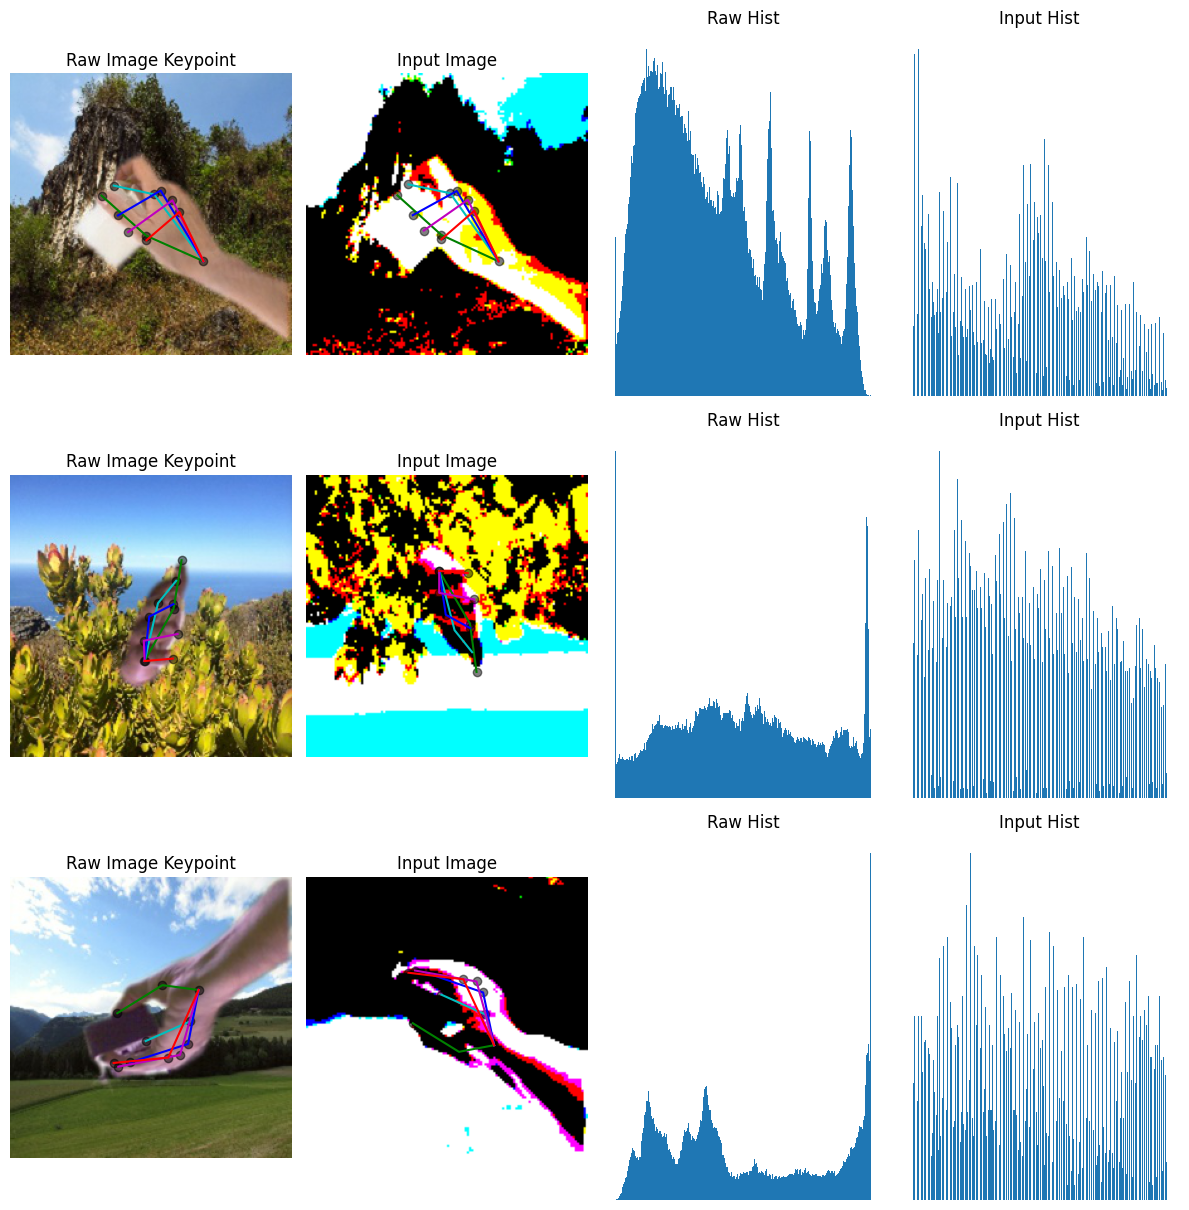

In [10]:
show_data(train_dataset, n_samples=4)

In [11]:
# print(get_norm_params(train_dataloader))

2it [00:10,  5.44s/it]


KeyboardInterrupt: ignored

In [12]:
val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

[1048   50 1504  816  740 1868  821]


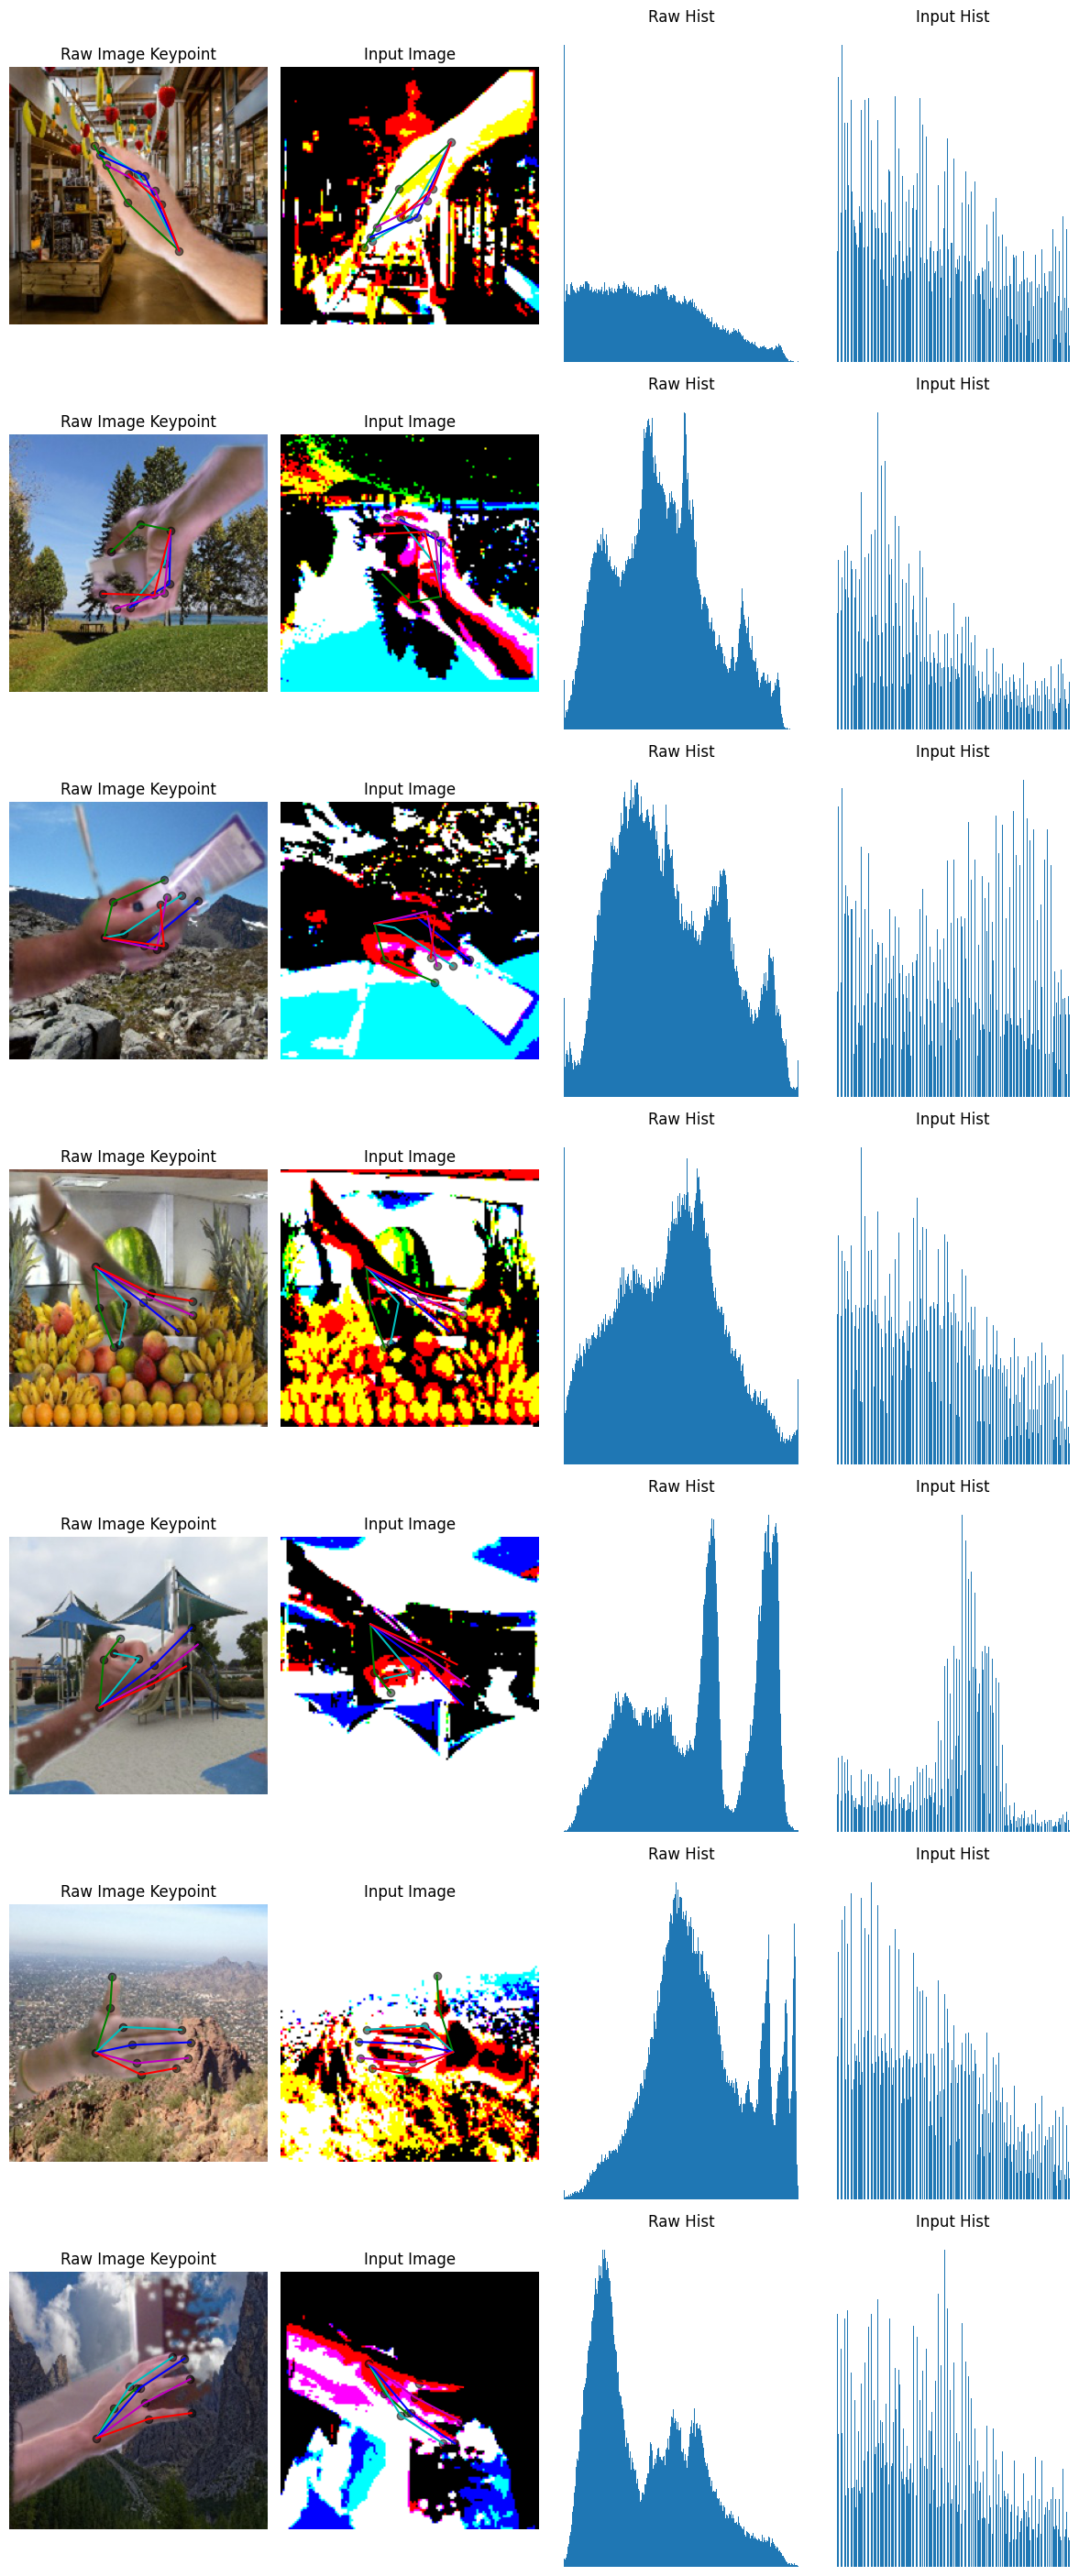

In [13]:
show_data(val_dataset, n_samples=8)

In [14]:
model = ShallowUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

criterion = IoULoss()
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=5, verbose=True, threshold=0.00001
)

In [18]:
trainer = Trainer(model, criterion, optimizer, config, scheduler)
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/1000, Train Loss=0.9203412728, Val Loss=0.8592026176
Epoch: 2/1000, Train Loss=0.8375046883, Val Loss=0.8119714536
Epoch: 3/1000, Train Loss=0.797614846, Val Loss=0.7906961892
Epoch: 4/1000, Train Loss=0.7709891489, Val Loss=0.7630698274
Epoch: 5/1000, Train Loss=0.7501891787, Val Loss=0.7546771852
Epoch: 6/1000, Train Loss=0.7337358198, Val Loss=0.7517859849
Epoch: 7/1000, Train Loss=0.7190518317, Val Loss=0.7303829019
Epoch: 8/1000, Train Loss=0.7052696176, Val Loss=0.6949868202
Epoch: 9/1000, Train Loss=0.6914145763, Val Loss=0.7039728833
Epoch: 10/1000, Train Loss=0.6793188059, Val Loss=0.6854266524
Epoch: 11/1000, Train Loss=0.6693175101, Val Loss=0.6716626446
Epoch: 12/1000, Train Loss=0.6608538094, Val Loss=0.6637190508
Epoch: 13/1000, Train Loss=0.6514986019, Val Loss=0.661461833
Epoch: 14/1000, Train Loss=0.6446300664, Val Loss=0.6541757307
Epoch: 15/1000, Train Loss=0.6366125095, Val Loss=0.6442987817
Epoch: 16/1000, Train Loss=0.6300549152, Val Loss=0.644032032
Epoc

KeyboardInterrupt: ignored

In [19]:
torch.save(model.state_dict(), "/content/fine")

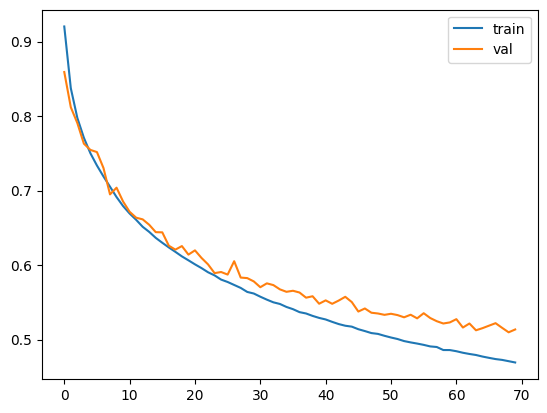

/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints


In [20]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()
print('/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints')

In [21]:
config = {
    "data_dir": "/content/drive/My Drive/Skripsi_GoogleColab/data",
    "model_path": "fine",
    "test_batch_size": 4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [24]:
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

In [25]:
model = ShallowUNet(3, 11)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device("cuda"))
)
model.eval()
print("Model loaded")

Model loaded


In [26]:
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

100%|██████████| 250/250 [01:55<00:00,  2.17it/s]


In [27]:
error = np.mean(accuracy_all)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [MODEL_IMG_SIZE, RAW_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )

Average error per keypoint: 15.8% from image size
Average error per keypoint: 20 pixels for image 128x128
Average error per keypoint: 35 pixels for image 224x224


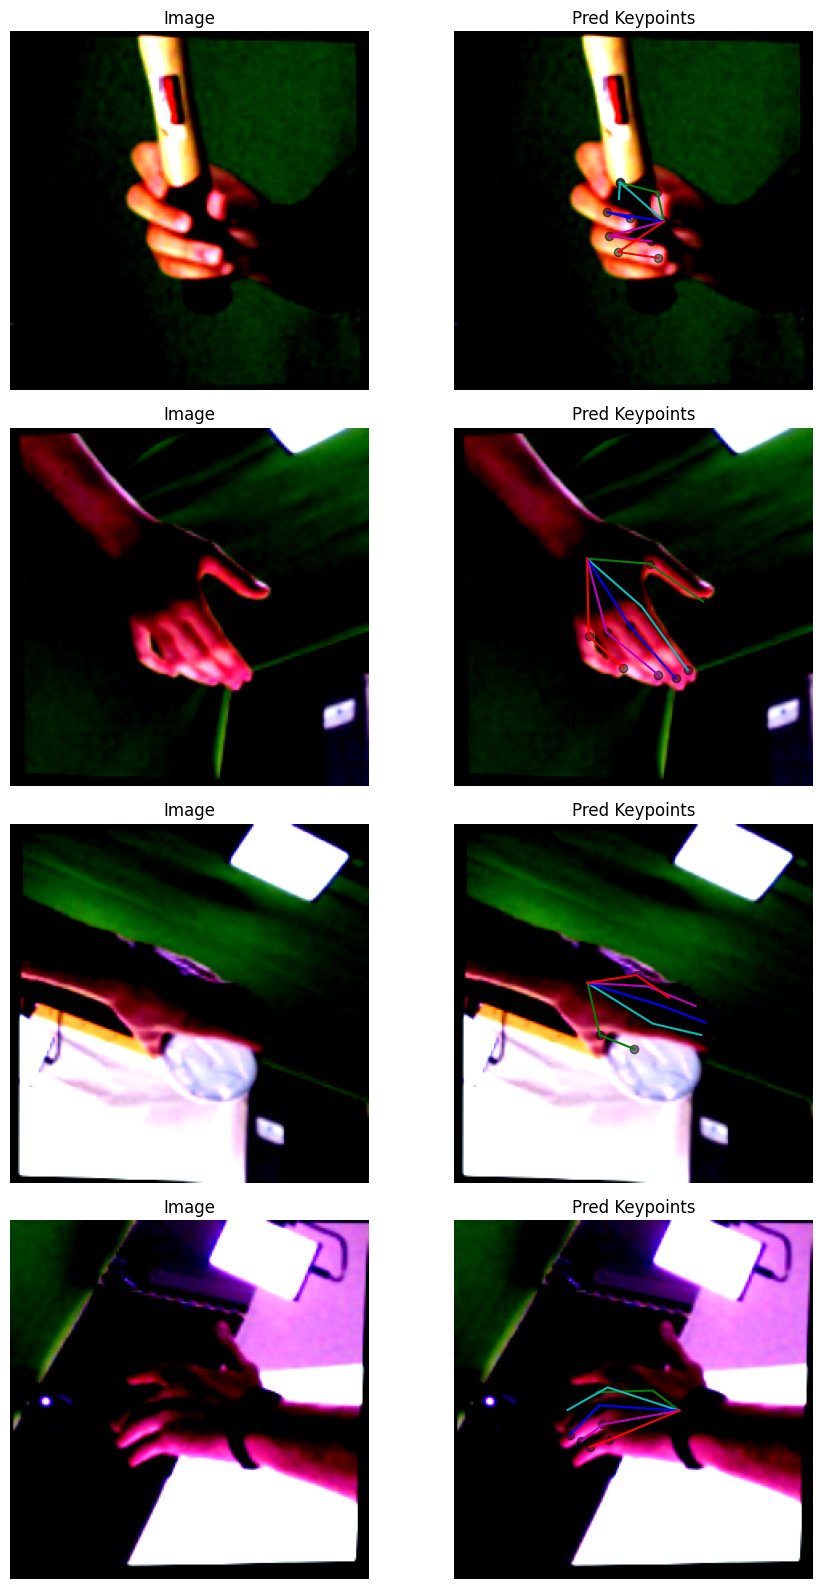

In [49]:
for data in test_dataloader:
    show_batch_predictions(data, model)
    break